# Xray Classification

#### For fixing SSL error

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Setup Dependencies

In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

import pickle

import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


### Data selection

In [3]:
train_data_dir = '../data/TRAIN' #location of training data
validation_data_dir = '../data/VAL' #location of validation data

### Data preprocessing

In [4]:
# dimensions of our images.
img_width, img_height = 299, 299

# number of samples used for determining the samples_per_epoch
nb_train_samples = 65
nb_validation_samples = 10
epochs = 20
batch_size = 5  

### Data transformation

In [5]:
# Generate batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# see: https://keras.io/preprocessing/image/
train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1]
        shear_range=0.2,      
        zoom_range=0.2,    
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)  


val_datagen = ImageDataGenerator(
         rescale=1./255)       # normalize pixel values to [0,1]


# Takes the path to a directory & generates batches of augmented data.
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# Takes the path to a directory & generates batches of augmented data.
validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


### Modeling

In [6]:
# Keras Applications are deep learning models 
# that are made available alongside pre-trained weights. 
# These models can be used for prediction, feature extraction, 
# and fine-tuning.
# Weights are downloaded automatically when instantiating a model. 
# They are stored at ~/.keras/models/.
base_model = applications.InceptionV3(weights='imagenet', 
                                      include_top=False, 
                                      input_shape=(img_width, img_height, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# The Sequential model is a linear stack of layers.
# You can create a Sequential model by passing 
# a list of layer instances to the constructor:
model_top = Sequential()
# Max pooling operation for spatial data.
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], 
                                     data_format=None)),  
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
13/13 [==============================] - 43s 3s/step - loss: 0.5223 - acc: 0.7077 - val_loss: 0.2358 - val_acc: 1.0000
Epoch 2/20
13/13 [==============================] - 31s 2s/step - loss: 0.2821 - acc: 0.8923 - val_loss: 0.0291 - val_acc: 1.0000
Epoch 3/20
13/13 [==============================] - 31s 2s/step - loss: 0.1317 - acc: 0.9385 - val_loss: 0.0247 - val_acc: 1.0000
Epoch 4/20
13/13 [==============================] - 31s 2s/step - loss: 0.0922 - acc: 0.9538 - val_loss: 0.0308 - val_acc: 1.0000
Epoch 5/20
13/13 [==============================] - 31s 2s/step - loss: 0.2650 - acc: 0.8923 - val_loss: 0.0213 - val_acc: 1.0000
Epoch 6/20
13/13 [==============================] - 31s 2s/step - loss: 0.0689 - acc: 0.9692 - val_loss: 0.0286 - val_acc: 1.0000
Epoch 7/20
13/13 [==============================] - 31s 2s/step - loss: 0.0203 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 8/20
13/13 [========================

### Model evaluation and testing

In [9]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


<Figure size 640x480 with 1 Axes>

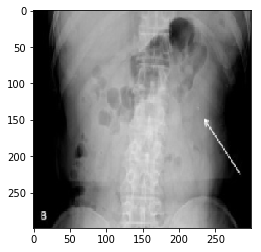

Predicted: [[0.99990237]] Abd X-ray


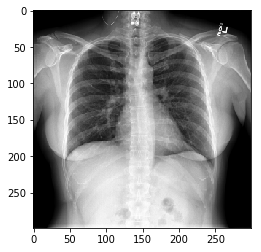

Predicted: [[1.0327468e-09]] Chest X-ray


In [10]:
test_dir_chest='../data/TRAIN/openI_abd_xray/openI_2.png' #change to location of chest x-ray
test_dir_abd='../data/TRAIN/openI_CXR/3_IM-1384-1001.png'  #change to location of abd x-ray

img_chest = image.load_img(test_dir_chest, target_size=(img_width, img_height))
img_abd = image.load_img(test_dir_abd, target_size=(img_width, img_height))

plt.imshow(img_chest)
plt.show()

img_chest = image.img_to_array(img_chest)
x = np.expand_dims(img_chest, axis=0) * 1./255
score = model.predict(x)
print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

plt.imshow(img_abd)
plt.show()

img_abd = image.img_to_array(img_abd)
x = np.expand_dims(img_abd, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')


### Save model

In [11]:
MODEL_DIR = "../models/model.pkl"

In [12]:
pickle.dump(model, open(MODEL_DIR,"wb"))

### Model deployment

In [13]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

import pickle

import numpy as np
from keras.preprocessing import image

class XRayModel:
    
    def __init__(self,model_location):
        with open(model_location, 'rb') as f:
            self.model = pickle.load(f)
        self.img_width, self.img_height = 299, 299
        
    def classify(self, image_dir):
        image_to_classify = image.load_img(image_dir, 
                                 target_size=(self.img_width, self.img_height))

        plt.imshow(image_to_classify)
        plt.show()

        image_to_classify = image.img_to_array(image_to_classify)
        x = np.expand_dims(image_to_classify, axis=0) * 1./255
        return self.model.predict(x)
        

        

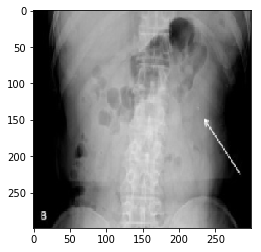

array([[0.99990237]], dtype=float32)

In [14]:
test_dir_chest='../data/TRAIN/openI_abd_xray/openI_2.png' #change to location of chest x-ray

classifier = XRayModel(MODEL_DIR)
classifier.classify(test_dir_chest)